# Modifying the default values for surface error and aperture efficiency.

We strongly encourage users of the GBT to rely on the Observatory-measured values and functions for surface error and aperture efficiency, which are implemented in `dysh`.   However, advanced users may wish to modify the values or functions; this example shows how to do that.


## Refresher on aperture efficiency and brightness scales
The aperture efficiency $\eta_a$, is determined by:

$$\eta_a = \eta_0 G(ZD) \exp(-(4\pi\epsilon/\lambda)^2),$$

where $\eta_0$ is the long wavelength aperture efficiency, $G(ZD)$ is the gain correction factor
at a zenith distance $ZD$, $\epsilon$ is the surface error, and $\lambda$ is the wavelength.

To scale antenna temperature $T_a$ to brightness tempeature $T_a^*$:

$$ T_a^* = T_a exp(\tau~A)/(\eta_a~\eta_l),$$

where $\tau$ is the zenith opacity, $A$ is the airmass, and $\eta_l$ is the loss efficiency.  To scale to flux $S_\nu$

$$ S_\nu = 2~k~T_a^*/A_p, $$

where $k$ is Boltzmann's constant is $A_p$ is the physical aperture of the telescope. 




## What `dysh does

When you calibrate and scale data through, e.g. `GBTFITSLoad.getps`, `dysh` uses the `GBTGainCorrection` class to manage the calculations described above. 

You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/appef_surferr.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/appeff_surferr.ipynb" download>here</a> and selecting "Save Link As".

## Loading Modules
We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.gaincorrection import GBTGainCorrection
from astropy import units as u

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url

## Data Retrieval

Download the example SDFITS data, if necessary.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits"
savepath = Path.cwd() / "data"
savepath.mkdir(exist_ok=True) # Create the data directory if it does not exist.
filename = from_url(url, savepath)

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename)

In [4]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


## Data Reduction

### Single Scan

Next we calibrate a few scans of the position switched observations, using a value for `zenith_op a single spectral window and polarization..

In [7]:
ps_scan_block = sdfits.getps(scan=[51,53,55], ifnum=0, plnum=0, fdnum=0, units="flux", zenith_opacity=0.08)

In [6]:
print(f"T_sys = {ps_scan_block[0].tsys.mean():.2f}")

T_sys = 19.36


#### Time Averaging

To time average the contents of a `ScanBlock` use its `timeaverage` method. Be aware that time averging will not check if the source is the same. 

By default time averaging uses the following weights: 
$$
\frac{T^{2}_{sys}}{\Delta\nu\Delta t}
$$
with $T_{sys}$ the system temperature, $\Delta\nu$ the channel width and $\Delta t$ the integration time. In `dysh` these are set using `weights='tsys'` (the default).

In [7]:
ta = ps_scan_block.timeaverage(weights='tsys')

#### Plotting

Plot the data and use different units for the spectral axis.

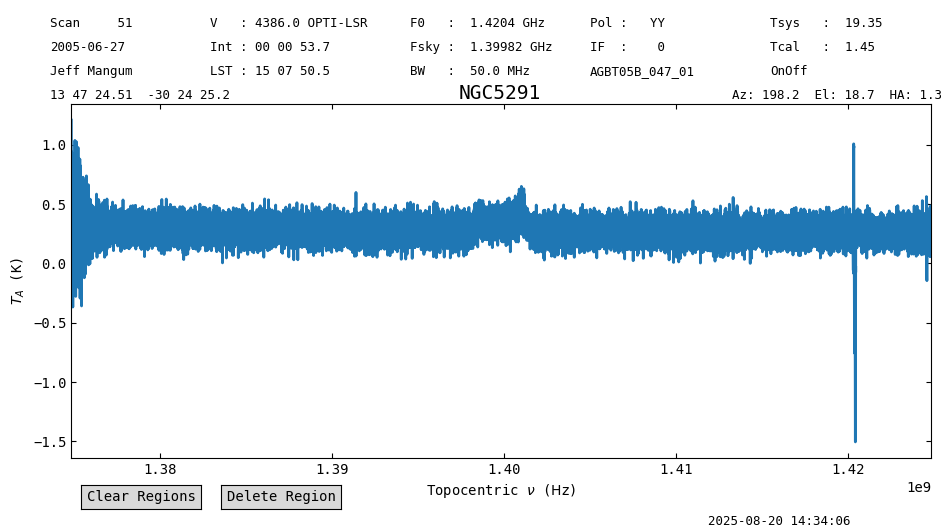

In [8]:
ta.plot()

Change the spectral axis units to km/s and the y-axis to mK, while also showing the spectra between 3600 and 5300 km/s, with the y-axis range between -100 and 1000 mK.

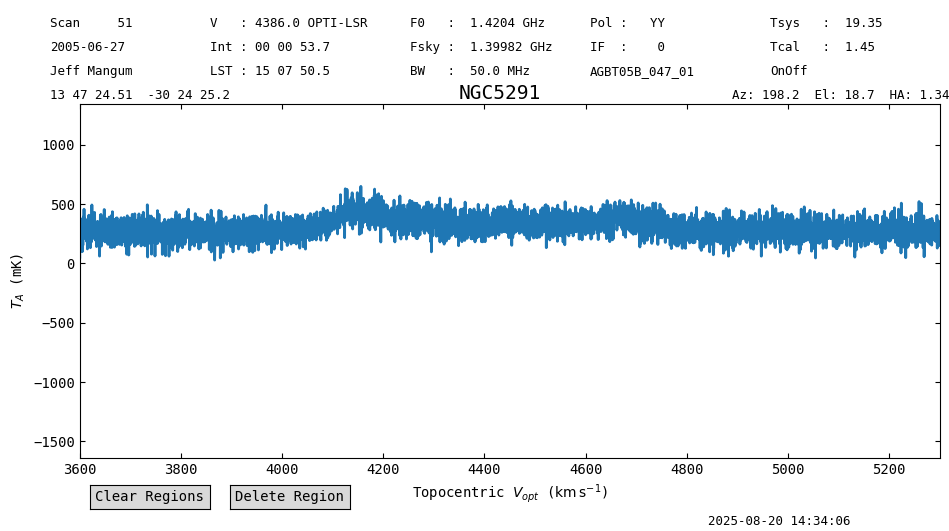

In [9]:
ta.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=-100, ymax=1000, xmin=3600, xmax=5300)

Switch back to GHz as the spectral axis unit.

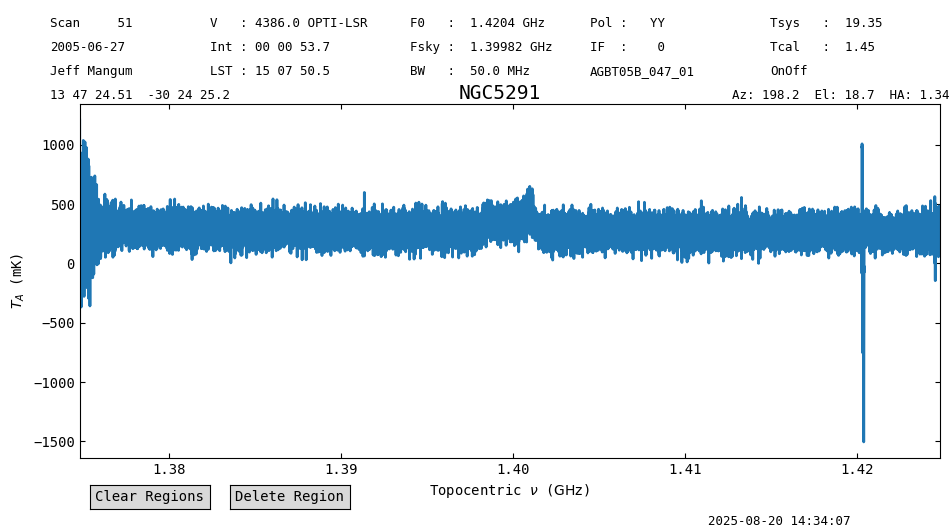

In [10]:
ta.plot(xaxis_unit="GHz", ymin=-100, ymax=1000, yaxis_unit="mK")

#### Baseline Subtraction
The following code cells show how to subtract a polynomial baseline from the data. This example uses an order 2 polynomial, and excludes the regions between 3800 and 5000 km/s, where a line is detected. The use of `remove=True` will remove the best fit baseline model from the spectrum.


For a polynomial model one may need to normalize the frequency axis in channel space using `normalize=True`, to prevent poorly conditioned fits, but this will not allow you to undo the fit.

In [11]:
kms = u.km/u.s
ta.baseline(model="poly", degree=2, exclude=[3800*kms,5000*kms], remove=True)

When we plot the spectrum again, it has been baseline subtracted.

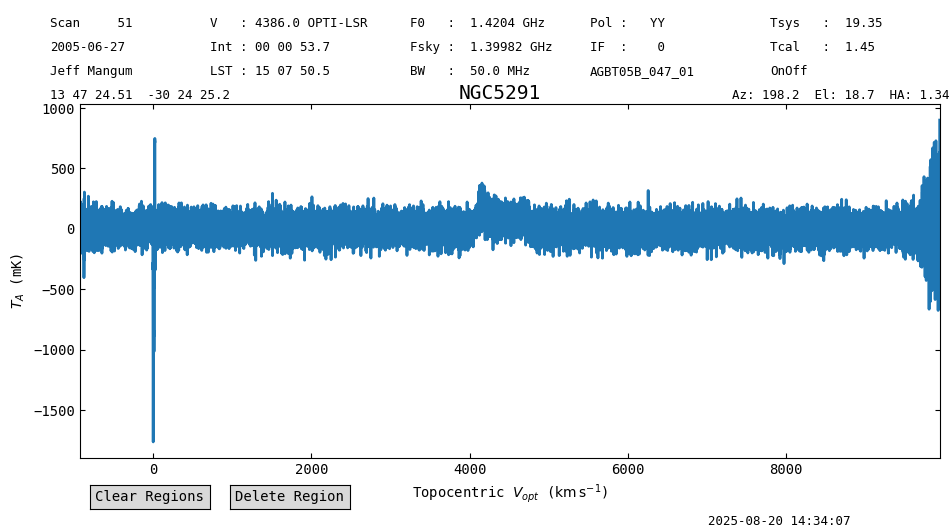

In [12]:
ta_plt = ta.plot(xaxis_unit="km/s", yaxis_unit="mK", ymin=-500, ymax=500)

We can inspect the best fit baseline coefficients.

In [13]:
print(ta.baseline_model)

<QuantityModel Polynomial1D(2, c0=0.27098986, c1=0.02448574, c2=0.01186811, domain=(1424816838.1210938, 1374818364.0)), input_units=Hz, return_units=K>


And save the figure.

In [14]:
output_dir = Path.cwd() / "output"
ta_plt.savefig(output_dir / "baselined_removed.png")

#### Using Selection

The following code shows how to calibrate scan 51 using selection. At this time selection does not know about signal and reference scan pairs, so the selection must include both scans, otherwise the calibration will fail.

In [15]:
sdfits.select(scan=[51,52])
sdfits.selection.show()

 ID    TAG      SCAN  # SELECTED
--- --------- ------- ----------
  0 3bd5d04c6 [51,52]         88


In [16]:
sb = sdfits.getps(plnum=0, ifnum=0, fdnum=0)

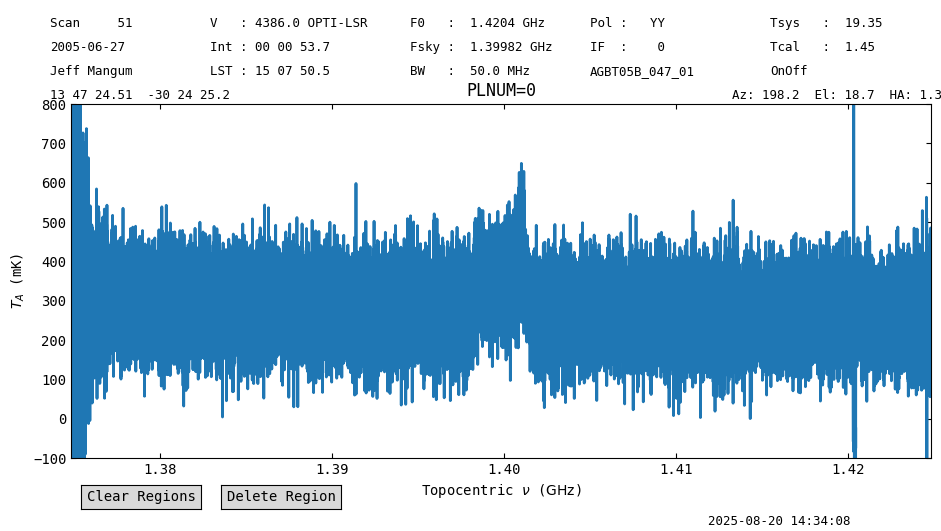

In [17]:
ta2 = sb.timeaverage(weights='tsys')
ta2.plot(xaxis_unit="GHz", ymin=-100, ymax=800, yaxis_unit="mK", title="PLNUM=0")

We can calibrate the other polarization, with the scan numbers already selected.

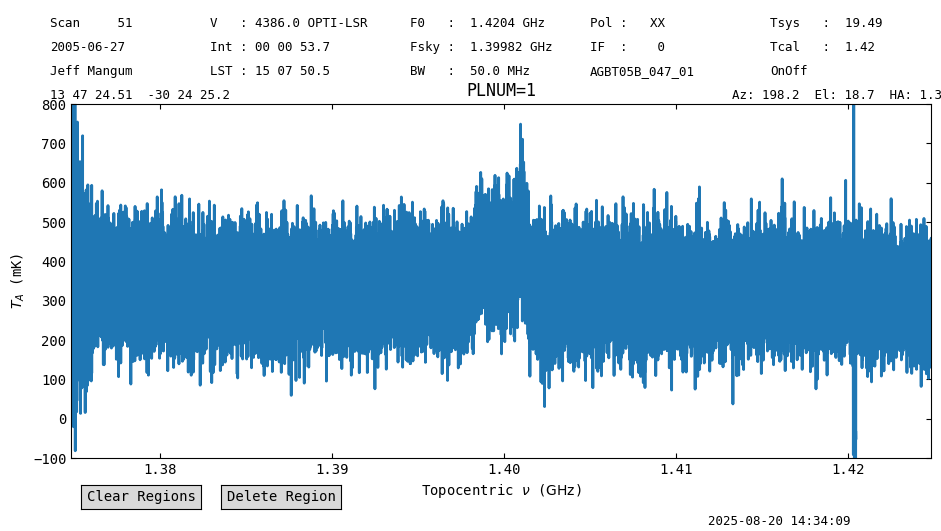

In [18]:
sb = sdfits.getps(plnum=1, fdnum=0, ifnum=0)
ta3 = sb.timeaverage(weights='tsys')
ta3.plot(xaxis_unit="GHz", ymin=-100, ymax=800, yaxis_unit="mK", title="PLNUM=1")

#### Polarization Average
Average the polarizations and plot the result.

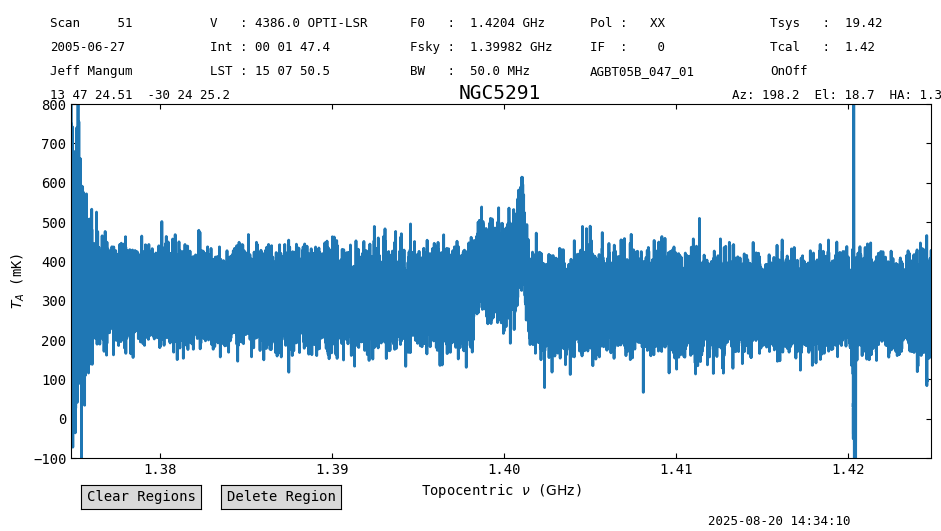

In [19]:
avg = ta2.average(ta3)
avg.plot(ymin=-100, ymax=800, yaxis_unit="mK", xaxis_unit="GHz")

### All Scans

Now we leverage the power of `dysh` to calibrate and time average all of the scans in the data.

We start by clearing the selection, so all of the scans are available.

In [20]:
sdfits.selection.clear()

Then, make a `ScanBlock` for spectral window 0 and polarization 0. Time average the scans in the `ScanBlock` into a single `Spectrum` and then remove a baseline.

In [21]:
ps_scan_block_0 = sdfits.getps(ifnum=0, plnum=0, fdnum=0)
ps_ta_0 = ps_scan_block_0.timeaverage(weights='tsys')
ps_ta_0.baseline(model="poly", degree=2, exclude=[3800*kms,5000*kms], remove=True)

Now plot and compare with the result for a single scan.

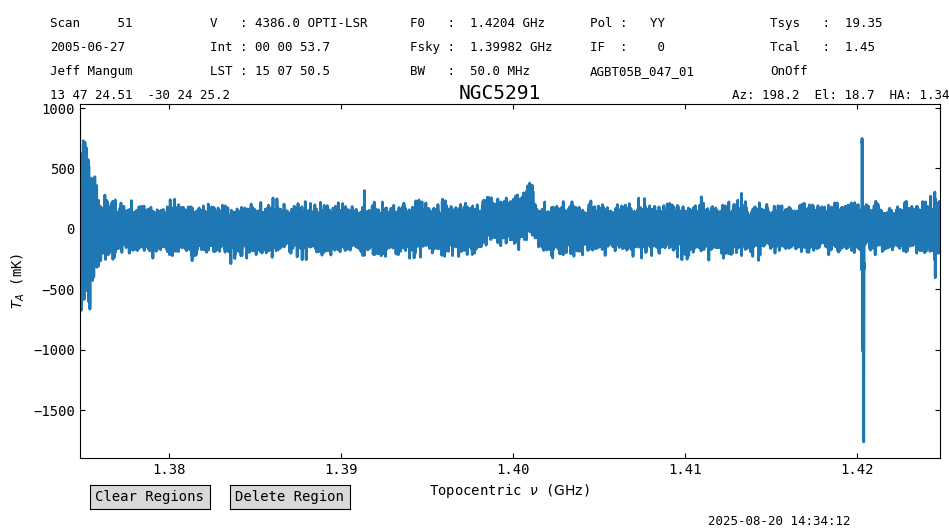

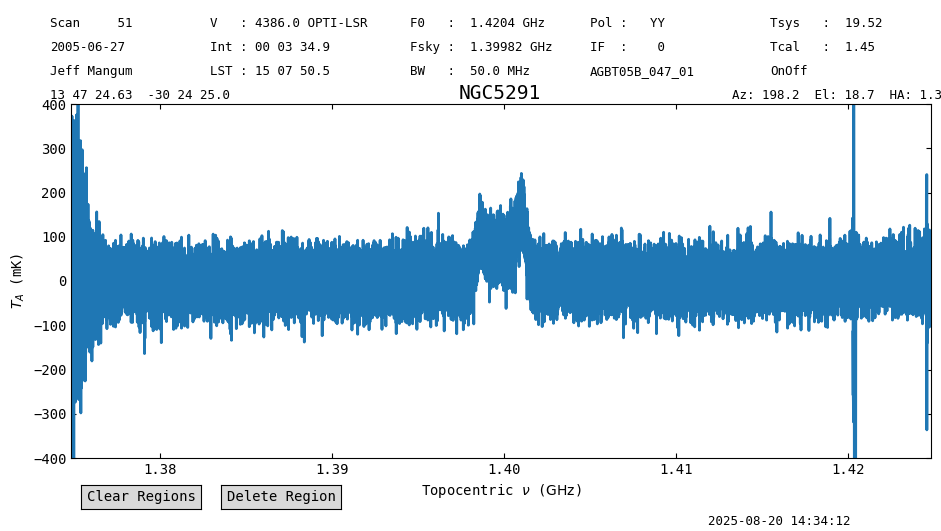

In [22]:
ta.plot(ymin=-400, ymax=400, yaxis_unit="mK", xaxis_unit="GHz")
ps_ta_0.plot(ymin=-400, ymax=400, yaxis_unit="mK", xaxis_unit="GHz")

The rms in the second Figure is almost half that of the first Figure. That is because there are four pairs of position switched scans in the data, so that results in a factor of $\sqrt{4}$ reduced noise when we average all the data.